In [88]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import Thermobar as pt
import PySulfSat as ss
import DiadFit as pf

In [89]:
plt.rcParams["font.family"] = 'arial'
plt.rcParams["font.size"] =12
plt.rcParams["mathtext.default"] = "regular"
plt.rcParams["mathtext.fontset"] = "dejavusans"
plt.rcParams['patch.linewidth'] = 1
plt.rcParams['axes.linewidth'] = 1
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"
plt.rcParams["xtick.major.size"] = 6 # Sets length of ticks
plt.rcParams["ytick.major.size"] = 4 # Sets length of ticks
plt.rcParams["ytick.labelsize"] = 12 # Sets size of numbers on tick marks
plt.rcParams["xtick.labelsize"] = 12 # Sets size of numbers on tick marks
plt.rcParams["axes.titlesize"] = 14 # Overall title
plt.rcParams["axes.labelsize"] = 14 # Axes labels

## Load in the combined spreadsheet from the supplement

In [90]:
df=pd.read_excel(r'C:\Users\penny\Box\Berkeley_new\Raman\Raman technical paper\Supporting_Info\Supporting_information_Draft1.xlsx',
                  sheet_name='power_series')
df['Type'].tail()

407    NaN
408    NaN
409    NaN
410    NaN
411    NaN
Name: Type, dtype: object

In [91]:
Iceland=df['Type']=='Icelandic FI'
df_Iceland=df.loc[Iceland]

df_notIceland=df.loc[~Iceland]
df_Iceland['Series_Name'].unique()

len(df_Iceland['Series_Name'].unique())

## Lets load the combined heat ones. 
df2=pd.read_excel(r'C:\Users\penny\Box\Berkeley_new\Raman\Raman technical paper\Supporting_information_Draft1.xlsx', sheet_name='Combined_power_heating_series')
df2_power=df2.loc[df2['Series_Type']=='power']

## Charlottes volcanica data
df_all_excel=pd.read_excel(r'C:\Users\penny\Box\Berkeley_new\Raman\Raman technical paper\Laser_power_Series\PowerSeriesCompilation.xlsx')
df_Volc=df_all_excel.loc[df_all_excel['Sample Name'].str.contains('ubble')]

## Figure 12 c-e - Individual Icelandic heating series

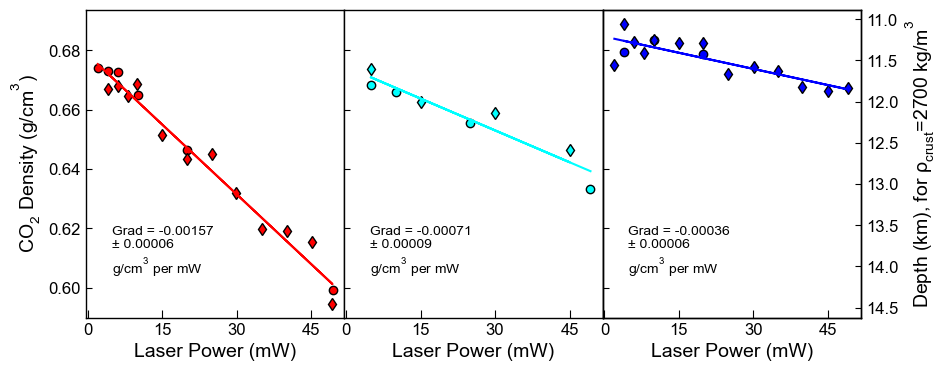

In [92]:


# Define the 3 series you want to plot
series_list = ['B22_1_FIA', 'B26_c11_FIX', 'B31_c8']
colors = ['red', 'cyan', 'blue']

# Create the plot
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 4), sharey=True, sharex=True, gridspec_kw={'wspace': 0})
axes = [ax1, ax2, ax3]

# Loop through each series
for i, (name, color) in enumerate(zip(series_list, colors)):
    ax = axes[i]
    
    df_inclusion = df_Iceland[df_Iceland['filename'].str.contains(name)]

    down_mask = df_inclusion['filename'].str.contains('down', case=False, na=False)
    not_down_mask = ~down_mask

    # Plot points
    ax.plot(df_inclusion.loc[down_mask, 'power (mW)'],
            df_inclusion.loc[down_mask, 'Density g/cm3'],
            'ok', mfc=color, label='down')

    ax.plot(df_inclusion.loc[not_down_mask, 'power (mW)'],
            df_inclusion.loc[not_down_mask, 'Density g/cm3'],
            'dk', mfc=color, label='not down')

    # Fit line
    stats = pt.calculate_R2(df_inclusion['power (mW)'], df_inclusion['Density g/cm3'])
    ax.plot(stats['x_pred'], stats['y_pred'], '-', color=color)

    # Annotate gradient
    ax.annotate(
        f"Grad = {stats['Grad'].item():.5f} \n± {stats['Grad_err'].item():.5f} \ng/cm$^{{3}}$ per mW",
        xy=(0.1, 0.3), xycoords="axes fraction",
        ha='left', va='top', fontsize=10
    )

# === Axis labels and ticks ===
ax1.set_xticks([0, 15, 30, 45])
ax1.set_xlabel('Laser Power (mW)')
ax1.set_ylabel('CO$_2$ Density (g/cm$^3$)')
ax2.set_xlabel('Laser Power (mW)')
ax3.set_xlabel('Laser Power (mW)')

# === Depth axis on right of ax3 ===
def get_depth_for_rho(rho, T_K=1200+273.15):
    P_kbar = pf.calculate_P_for_rho_T(CO2_dens_gcm3=rho, T_K=T_K)['P_kbar']
    return (1e5 * P_kbar / (9.8 * 2700)).item()

ax1b = ax3.twinx()
ymin, ymax = ax1.get_ylim()
depth_min = get_depth_for_rho(ymax)
depth_max = get_depth_for_rho(ymin)
ax1b.set_ylim(depth_min, depth_max)
ax1b.set_ylabel('Depth (km), for ρ$_{crust}$=2700 kg/m$^3$')

# Save figure
fig.savefig('PowerSeries_Iceland.png', dpi=300, transparent=True)


## Figure 12 c-e

C:\Users\penny\AppData\Local\Temp\ipykernel_25728\3602276328.py:36: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  summary_all = pd.concat([summary_iceland, summary_noticeland, summary_df2], ignore_index=True)
C:\Users\penny\AppData\Local\Temp\ipykernel_25728\3602276328.py:41: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('hot')
C:\Users\penny\AppData\Local\Temp\ipykernel_25728\3602276328.py:73: UserWarning: Adding colorbar to a different Figure <Figure size 950x400 with 3 Axes> than <Figure size 950x400 with 3 Axes> which fig.colorbar is called on.
 

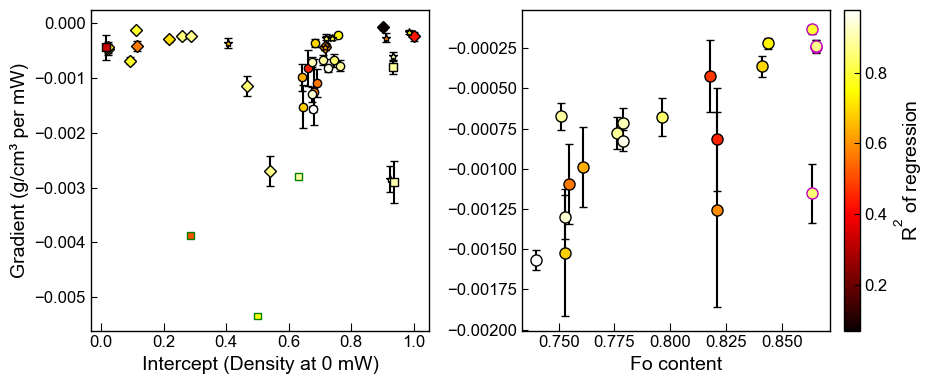

In [93]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from matplotlib.colors import Normalize
from scipy.stats import linregress

# Function to extract summary info
def summarize(df, dataset_label):
    rows = []
    for name in df['Series_Name'].unique():
        sub = df[df['Series_Name'] == name]
        if len(sub) < 2 or sub['power (mW)'].isna().any() or sub['Density g/cm3'].isna().any():
            continue
        x = sub['power (mW)']
        y = sub['Density g/cm3']
        slope, intercept, r, p, stderr = linregress(x, y)
        Fo_val = sub['Fo'].dropna().iloc[0] if 'Fo' in sub.columns and not sub['Fo'].dropna().empty else None
        is_MI = 'MI' in name
        rows.append({
            'Series_Name': name,
            'Dataset': dataset_label,
            'Gradient': slope,
            'Error_on_Gradient': stderr,
            'R2': r ** 2,
            'Fo': Fo_val,
            'Intercept': intercept,
            'is_MI': is_MI
        })
    return pd.DataFrame(rows)

# Combine all summaries
summary_iceland = summarize(df_Iceland, 'Iceland')
summary_noticeland = summarize(df_notIceland, 'notIceland')
summary_df2 = summarize(df2_power, 'df2_power')

summary_all = pd.concat([summary_iceland, summary_noticeland, summary_df2], ignore_index=True)

# Set up plot
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(9.5, 4), sharey=False)
norm = Normalize(summary_all['R2'].min(), summary_all['R2'].max())
cmap = get_cmap('hot')

# === Left Panel: Gradient vs Intercept ===
for _, row in summary_all.iterrows():
    color = cmap(norm(row['R2']))
    marker = 'o' if row['Dataset'] == 'Iceland' else ('s' if row['is_MI'] else ('*' if row['Dataset'] == 'df2_power' else 'D'))
    ax0.errorbar(row['Intercept'], row['Gradient'], yerr=row['Error_on_Gradient'], fmt=marker,
                 color=color, ecolor='k', capsize=3, markersize=6, mec='k')

ax0.set_xlabel('Intercept (Density at 0 mW)')
ax0.set_ylabel('Gradient (g/cm³ per mW)')
#ax0.set_title('Gradient vs. Intercept (all series)')

# === Right Panel: Gradient vs Fo (Iceland only) ===
for _, row in summary_iceland.iterrows():
    color = cmap(norm(row['R2']))
    ax1.errorbar(row['Fo'], row['Gradient'], yerr=row['Error_on_Gradient'], fmt='o',
                 color=color, ecolor='k', capsize=3, markersize=8, mec='k')

ax1.set_xlabel('Fo content')
#ax1.set_title('Gradient vs. Fo (Iceland only)')

# Add colorbar
for _, row in summary_noticeland.iterrows():
    color = cmap(norm(row['R2']))
    ax1.errorbar(row['Fo'], row['Gradient'], yerr=row['Error_on_Gradient'], fmt='o',
                 color=color, ecolor='k', capsize=3, markersize=8, mec='m')


# sc = ax1.scatter(summary_noticeland['Fo'], summary_noticeland['Gradient'], c=summary_noticeland['R2'],
#                  cmap='hot', norm=norm, edgecolor='m', s=0)

cbar = plt.colorbar(sc, ax=ax1, fraction=0.05, pad=0.04)
cbar.set_label(r'$R^2$ of regression')

# Optional extra overlay (from original code)
ax0.scatter(df_Volc['Int'], df_Volc['Grad'], c=cmap(norm(df_Volc['R2'])),
            edgecolor='g', s=25, marker='s')



plt.tight_layout()
plt.savefig("Fo_vs_Intercept_Gradient_Summary.png", dpi=300)
plt.show()


In [94]:
summary_noticeland

,Series_Name,Dataset,Gradient,Error_on_Gradient,R2,Fo,Intercept,is_MI
0,ML22_77_power,notIceland,-0.000481,0.000108,0.798728,NaN,0.020274,False
1,MP2_204_power,notIceland,-0.000437,0.000101,0.702200,NaN,0.021015,False
2,ML22_77_4_MIA_power,notIceland,-0.000440,0.000226,0.322648,NaN,0.015594,True
3,FG04-A11-9_power,notIceland,-0.000416,0.000089,0.563405,NaN,0.115568,False
4,FG04-A11-16_power,notIceland,-0.000298,0.000050,0.701321,NaN,0.217504,False
5,FG04-A11-4_power,notIceland,-0.002695,0.000278,0.870278,NaN,0.539576,False
6,FG19_101_FIB_power,notIceland,-0.000072,0.000045,0.071476,NaN,0.902449,False
7,Fo1_power,notIceland,-0.000687,0.000066,0.783863,NaN,0.091632,False
8,FG04_A13_12_power,notIceland,-0.000440,0.000049,0.595240,NaN,0.716462,False
9,p3_FI4,notIceland,-0.000243,0.000078,0.428449,NaN,1.000605,False


## Supplementary Figures - Iceland ones

In [95]:
import matplotlib.pyplot as plt
import numpy as np
import string
from scipy.stats import linregress

# Filter for Icelandic FI
unique_series = df_Iceland['Series_Name'].unique()

# Layout settings
ncols = 2
nrows = 2
per_fig = ncols * nrows

# Panel letter helper
def panel_label(index):
    # Supports a–z, aa–zz, etc.
    letters = string.ascii_lowercase
    result = ''
    while True:
        index, remainder = divmod(index, 26)
        result = letters[remainder] + result
        if index == 0:
            break
        index -= 1
    return result

# Helper to chunk data into figures
def chunks(lst, n):
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

# Track global panel count
panel_index = 0

# Loop through each group of subplots
for fig_num, series_chunk in enumerate(chunks(unique_series, per_fig), start=1):
    fig, axes = plt.subplots(nrows, ncols, figsize=(12, 10), constrained_layout=True)
    axes = axes.flatten()

    for ax, series_name in zip(axes, series_chunk):
        subset = df_Iceland[df_Iceland['Series_Name'] == series_name].copy()

        # === Plot points ===
        for idx, row in subset.iterrows():
            marker = 'o' if 'down' in str(row['filename']).lower() else 'd'
            ax.errorbar(row['power (mW)'], row['Density g/cm3'],
                        yerr=row['σ Density g/cm3'], xerr=0,
                        fmt=marker, ecolor='k', elinewidth=0.8,
                        mfc='cyan', ms=10, mec='k', capsize=3)

        # === Regression ===
        x = subset['power (mW)']
        y = subset['Density g/cm3']

        if len(x) >= 2:
            slope, intercept, r_value, p_value, std_err = linregress(x, y)
            x_fit = np.linspace(x.min(), x.max(), 100)
            y_fit = slope * x_fit + intercept
            ax.plot(x_fit, y_fit, 'k--', linewidth=1.5)

            ax.annotate(f"Slope = {slope:.4f}\nR² = {r_value**2:.2f}",
                        xy=(0.5, 0.95), xycoords='axes fraction',
                        ha='left', va='top', fontsize=12)

        # === Title and panel letter ===
        Fo_val = subset['Fo'].dropna().iloc[0] if not subset['Fo'].dropna().empty else np.nan
        Fo_str = f"{Fo_val:.3f}" if not np.isnan(Fo_val) else 'N/A'
        ax.set_title(f"{series_name}, Fo = {Fo_str}")
        ax.annotate(f"{panel_label(panel_index)})", xy=(0.02, 0.98), xycoords='axes fraction',
                    fontsize=14, fontweight='bold', ha='left', va='top')

        ax.set_xlabel('Power (mW)')
        ax.set_ylabel('Density (g/cm$^3$)')

        panel_index += 1

    # Hide unused axes
    for j in range(len(series_chunk), len(axes)):
        axes[j].set_visible(False)

    fig.savefig(f'Iceland_power_{fig_num}.jpg', dpi=300)
    plt.close(fig)


## Same for non Icelandic ones

In [96]:
import matplotlib.pyplot as plt
import numpy as np
import string
from scipy.stats import linregress

# Use unique Series_Name values from df_notIceland
unique_series = df_notIceland['Series_Name'].unique()

# Layout settings
ncols = 2
nrows = 2
per_fig = ncols * nrows

# Letter generator (supports a–z, aa–zz...)
def panel_label(index):
    letters = string.ascii_lowercase
    result = ''
    while True:
        index, remainder = divmod(index, 26)
        result = letters[remainder] + result
        if index == 0:
            break
        index -= 1
    return result

# Chunk helper
def chunks(lst, n):
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

# Track panel index across all figures
panel_index = 0

# Loop over chunks of 4 series per figure
for fig_num, series_chunk in enumerate(chunks(unique_series, per_fig), start=1):
    fig, axes = plt.subplots(nrows, ncols, figsize=(12, 10), constrained_layout=True)
    axes = axes.flatten()

    for ax, series_name in zip(axes, series_chunk):
        subset = df_notIceland[df_notIceland['Series_Name'] == series_name].copy()

        # Plot each point with marker type depending on filename
        for idx, row in subset.iterrows():
            marker = 'o' if 'down' in str(row['filename']).lower() else 'd'
            ax.errorbar(row['power (mW)'], row['Density g/cm3'],
                        yerr=row['σ Density g/cm3'], xerr=0,
                        fmt=marker, ecolor='k', elinewidth=0.8,
                        mfc='cyan', ms=10, mec='k', capsize=3)

        # Linear regression
        x = subset['power (mW)']
        y = subset['Density g/cm3']

        if len(x) >= 2:
            slope, intercept, r_value, p_value, std_err = linregress(x, y)
            x_fit = np.linspace(x.min(), x.max(), 100)
            y_fit = slope * x_fit + intercept
            ax.plot(x_fit, y_fit, 'k--', linewidth=1.5)

            ax.annotate(f"Slope = {slope:.4f}\nR² = {r_value**2:.2f}",
                        xy=(0.5, 0.95), xycoords='axes fraction',
                        ha='left', va='top', fontsize=12)

        # Annotate Fo and panel letter
        Fo_val = subset['Fo'].dropna().iloc[0] if not subset['Fo'].dropna().empty else np.nan
        Fo_str = f"{Fo_val:.3f}" if not np.isnan(Fo_val) else 'N/A'
        ax.set_title(f"{series_name}, Fo = {Fo_str}")
        ax.annotate(f"{panel_label(panel_index)})", xy=(0.02, 0.98), xycoords='axes fraction',
                    fontsize=14, fontweight='bold', ha='left', va='top')

        ax.set_xlabel('Power (mW)')
        ax.set_ylabel('Density (g/cm$^3$)')

        panel_index += 1

    # Hide unused axes in last figure
    for j in range(len(series_chunk), len(axes)):
        axes[j].set_visible(False)

    fig.savefig(f'notIceland_power_{fig_num}.jpg', dpi=300)
    plt.close(fig)


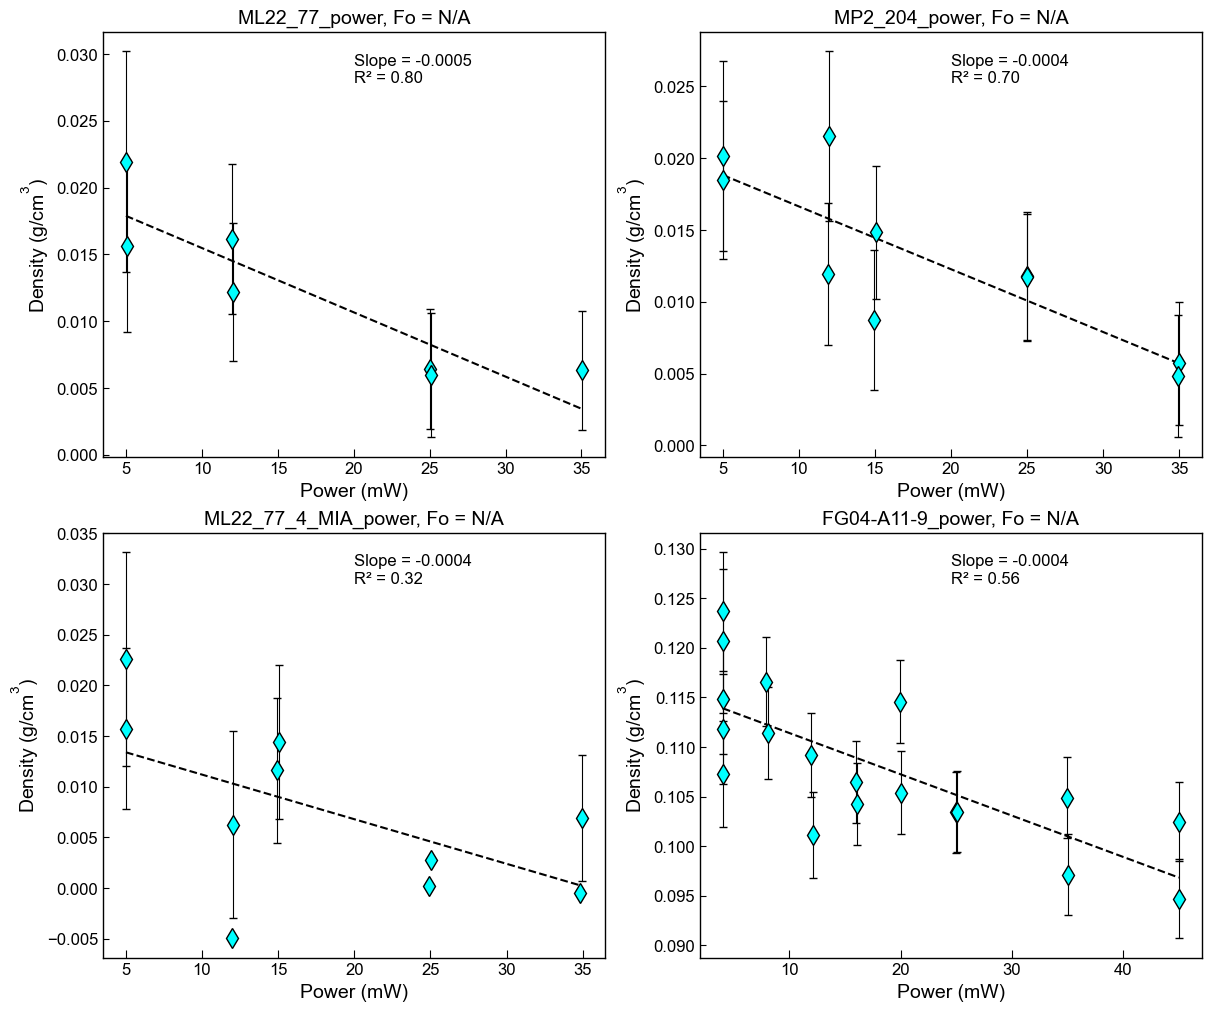

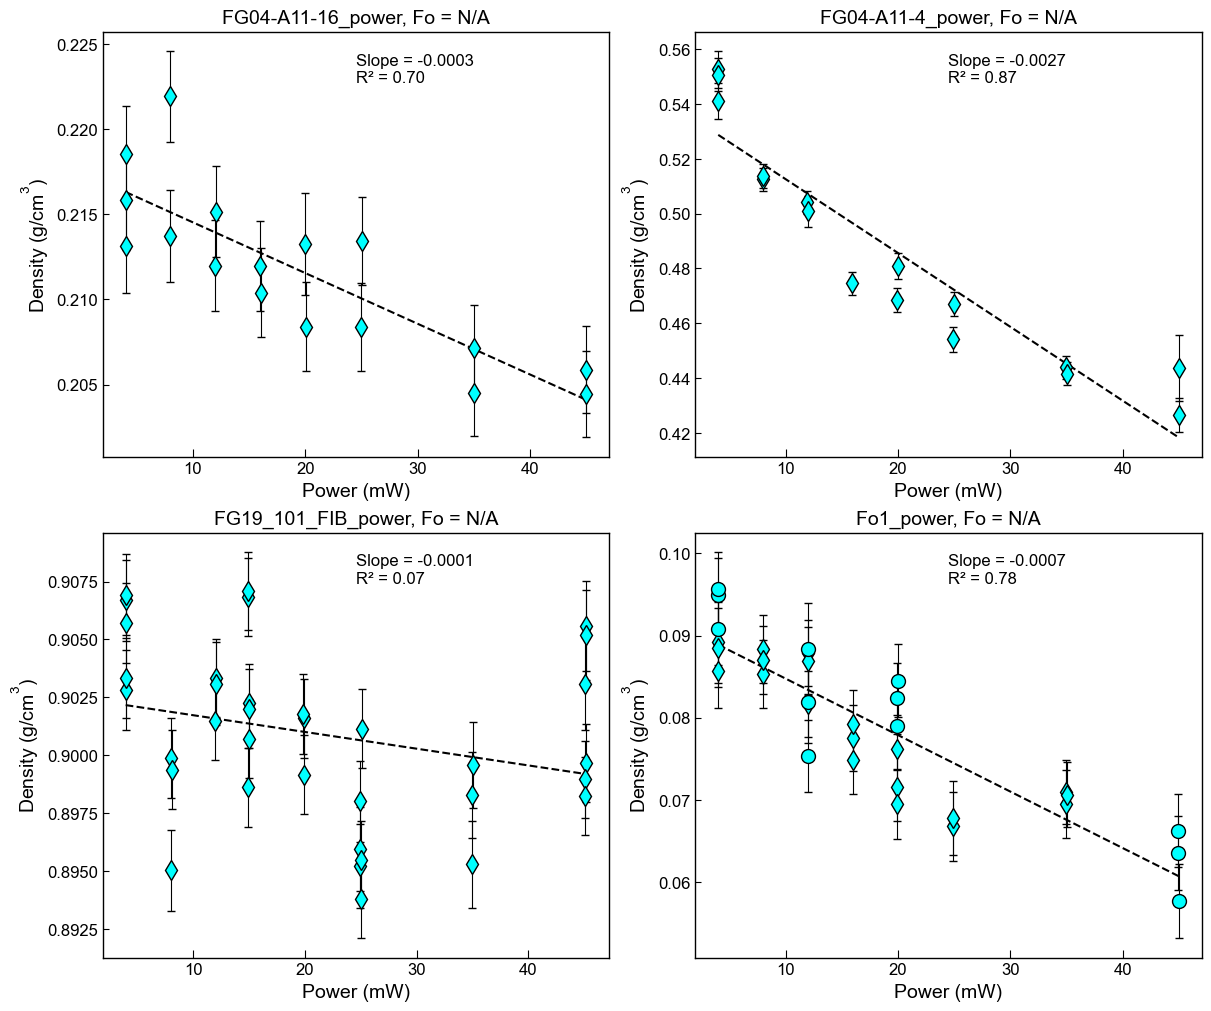

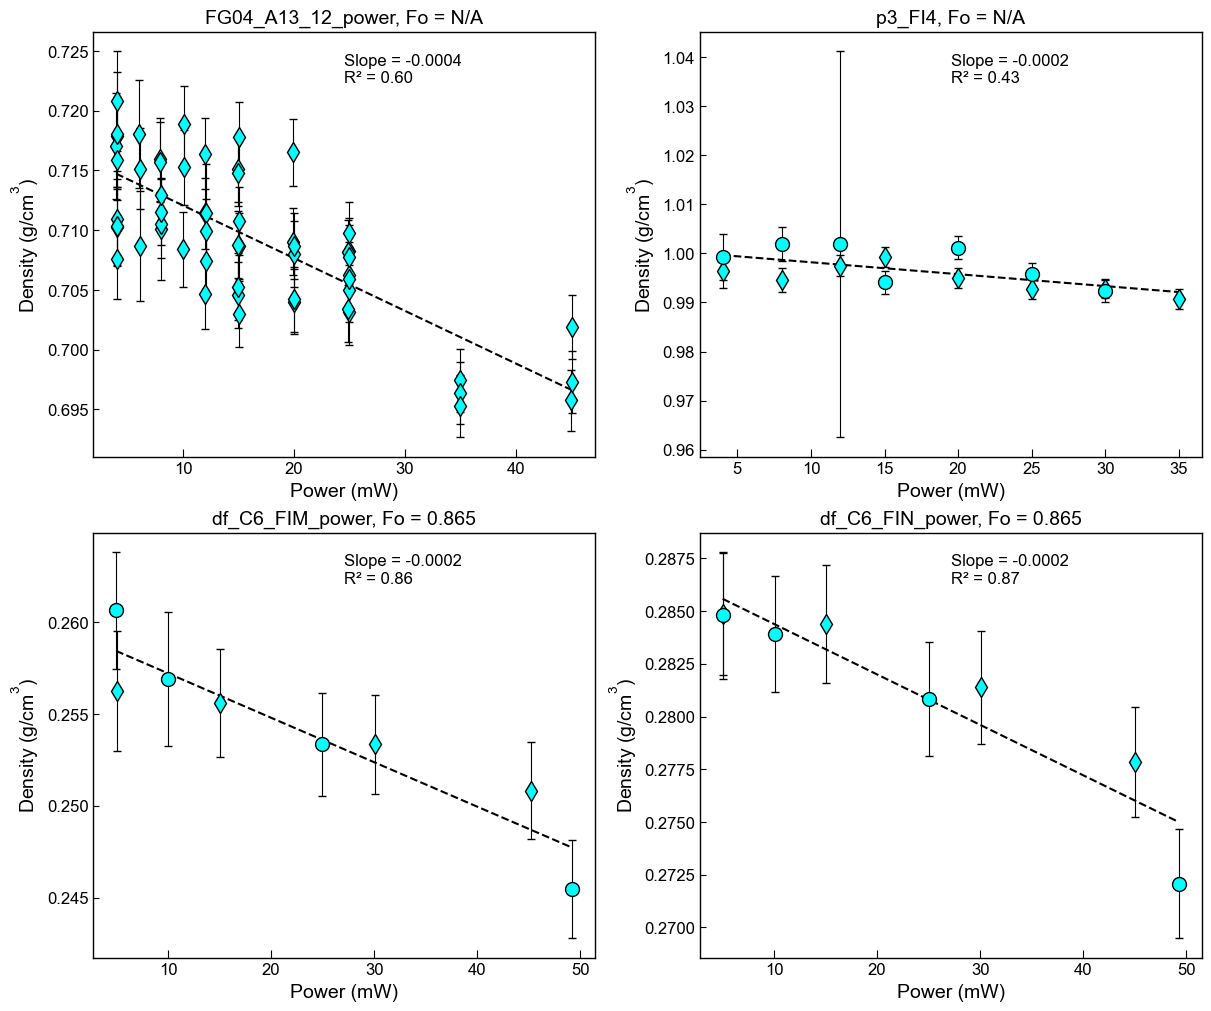

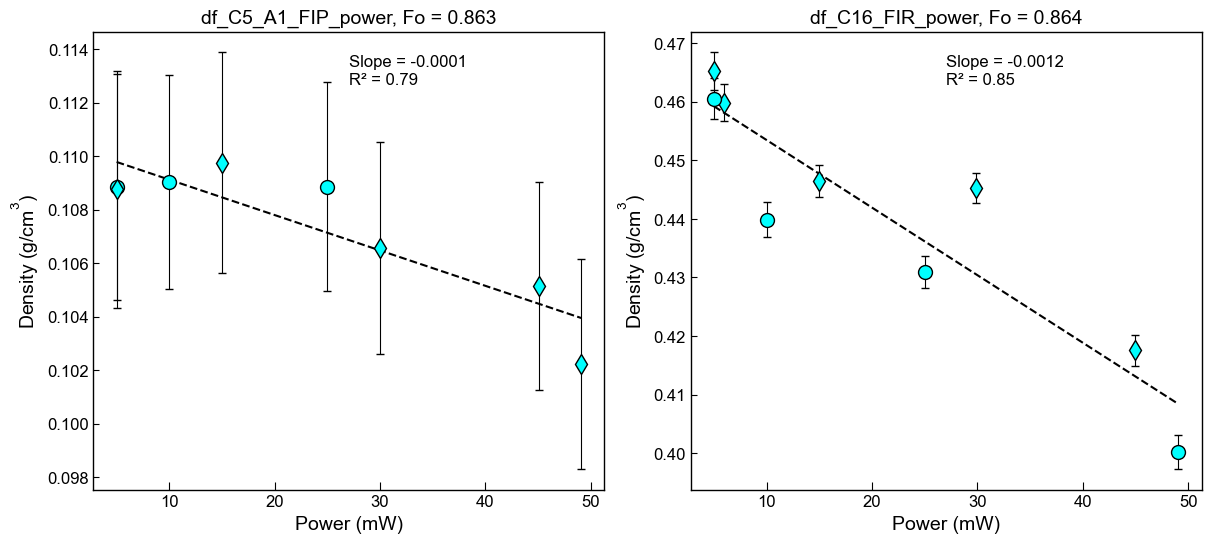

In [97]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress

# Filter for Icelandic FI

unique_series = df_notIceland['Series_Name'].unique()

# Layout
ncols = 2
nrows = 2
per_fig = ncols * nrows

def chunks(lst, n):
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

# Loop through each group of subplots
for fig_num, series_chunk in enumerate(chunks(unique_series, per_fig), start=1):
    fig, axes = plt.subplots(nrows, ncols, figsize=(12, 10), constrained_layout=True)
    axes = axes.flatten()

    for ax, series_name in zip(axes, series_chunk):
        subset = df_notIceland[df_notIceland['Series_Name'] == series_name].copy()

        # === Plot individual points with correct markers ===
        for idx, row in subset.iterrows():
            marker = 'o' if 'down' in str(row['filename']).lower() else 'd'
            ax.errorbar(row['power (mW)'], row['Density g/cm3'],
                        yerr=row['σ Density g/cm3'], xerr=0,
                        fmt=marker, ecolor='k', elinewidth=0.8,
                        mfc='cyan', ms=10, mec='k', capsize=3)

        # === Regression ===
        x = subset['power (mW)']
        y = subset['Density g/cm3']

        if len(x) >= 2:
            slope, intercept, r_value, p_value, std_err = linregress(x, y)
            x_fit = np.linspace(x.min(), x.max(), 100)
            y_fit = slope * x_fit + intercept
            ax.plot(x_fit, y_fit, 'k--', linewidth=1.5)

            # === Annotate gradient and R² ===
            ax.annotate(f"Slope = {slope:.4f}\nR² = {r_value**2:.2f}",
                        xy=(0.5, 0.95), xycoords='axes fraction',
                        ha='left', va='top', fontsize=12)

        Fo_val = subset['Fo'].dropna().iloc[0] if not subset['Fo'].dropna().empty else np.nan
        Fo_str = f"{Fo_val:.3f}" if not np.isnan(Fo_val) else 'N/A'

        ax.set_title(f"{series_name}, Fo = {Fo_str}")
        ax.set_xlabel('Power (mW)')
        ax.set_ylabel('Density (g/cm$^3$)')

    # Hide unused axes in final figure
    for j in range(len(series_chunk), len(axes)):
        axes[j].set_visible(False)

    fig.savefig(f'NOTIceland_power_{fig_num}.jpg', dpi=300)
 

## Iceland heating example

In [98]:
mask = df['filename'].str.contains('B26_c11_FIX')

## Gradient plot
- Penny needs to make a combined thing for all the different series to show against CO2 density. 

In [99]:
import matplotlib.pyplot as plt
import Thermobar as pt

comps =pd.DataFrame(data={'B22_1_FIA':0.739881757,
                        'B31_c8': 0.841028844,
                          'B27_c4': 0.843988556,
                          'B27_c19_a1':0.75477171,
                            'B31_c11_a1':0.760986133,
              'B31_c7_a1_FIA':0.776073432,
                'B23_1_FIA':0.820743717,
                  'B23_1_FIC': 0.820743717,
                    'B31_c6': 0.750965078, 
                    'B26_c11_FIX':0.779070861,
                    'B26_c11_FIZ': 0.779070861,
                    'B26_c8_a3_FIZ': 0.752845605,
                     'B26_c8_a3_FIX':0.752845605, 
                     'B31_c4': 0.796430578505229,
                     'B27_17': 0.818043881,
                       # Other analyses  
}, index=[0])

# === Reshape comps and merge ===
comps_long = comps.T.reset_index()
comps_long.columns = ['Inclusion', 'Fo']
merged_df = pd.merge(output_df, comps_long, on='Inclusion', how='left')

# === Color dictionary ===
color_dict = {
    'B22_1_FIA': 'red', 'B31_c8': 'blue', 'B27_c4': 'green', 'B27_c19_a1': 'purple',
    'B31_c11_a1': 'orange', 'B31_c7_a1_FIA': 'cyan', 'B23_1_FIA': 'magenta', 'B23_1_FIC': 'lime',
    'B31_c6': 'brown', 'B26_c11_FIZ': 'pink', 'B26_c11_FIX': 'white', 'B26_c8_a3_FIZ': 'cornflowerblue',
    'B26_c8_a3_FIX': 'grey', 'B31_c4': 'salmon', 'B27_17': 'midnightblue',
}

# === Check for missing color keys ===
inclusions = merged_df['Inclusion'].unique()
missing_colors = [incl for incl in inclusions if incl not in color_dict]
if missing_colors:
    print("Warning! These inclusions are missing in color_dict:", missing_colors)

# === Plotting ===
fig, ax = plt.subplots(figsize=(7, 4))

for i, row in merged_df.iterrows():
    ax.errorbar(row['Fo'], row['Gradient'],
                yerr=row['Error_on_Gradient'], fmt='s',
                ecolor='k', elinewidth=0.8,
                mfc=color_dict.get(row['Inclusion'], 'grey'),
                ms=10, mec='k', capsize=3)

# === Legend ===
handles, labels = [], []
for incl in inclusions:
    h = ax.errorbar([], [], fmt='s',
                    mfc=color_dict.get(incl, 'grey'),
                    mec='k', ms=10, label=incl)
    handles.append(h[0])
    labels.append(incl)
ax.legend(handles, labels, bbox_to_anchor=(1.05, 1), loc='upper left')

# === Labels ===
ax.set_xlabel('Olivine Fo content')
ax.set_ylabel('Gradient (g/cm$^{3}$ per mW)')

# === R² calculation and regression line ===
stats = pt.calculate_R2(merged_df['Fo'], merged_df['Gradient'])
R2_value = stats['R2']

# Plot regression line
ax.plot(stats['x_pred'], stats['y_pred'], '-k', lw=1)
ax.annotate(f"$R^2$ = {R2_value:.3f}", xy=(0.05, 0.95), xycoords='axes fraction',
            fontsize=10, ha='left', va='top')

# === Save ===
fig.savefig('Iceland_heating_rates.png', dpi=300, bbox_inches='tight')


NameError: name 'output_df' is not defined

R² = 0.506


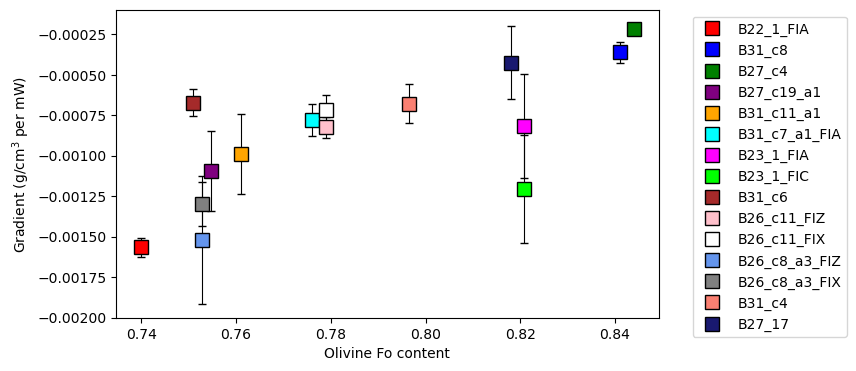

In [ ]:


# Reshape comps to long format (column: Inclusion, value: Chemistry_Value)
comps_long = comps.T.reset_index()
comps_long.columns = ['Inclusion', 'Fo']

# Now merge with your output_df
merged_df = pd.merge(output_df, comps_long, on='Inclusion', how='left')

# Show result
merged_df


color_dict = {
    'B22_1_FIA': 'red',
    'B31_c8': 'blue',
    'B27_c4': 'green',
    'B27_c19_a1': 'purple',
    'B31_c11_a1': 'orange',
    'B31_c7_a1_FIA': 'cyan',
    'B23_1_FIA': 'magenta',
    'B23_1_FIC': 'lime',
    'B31_c6': 'brown',
    'B26_c11_FIZ': 'pink',
    'B26_c11_FIX': 'white',
    'B26_c8_a3_FIZ': 'cornflowerblue',
    'B26_c8_a3_FIX': 'grey',
                         'B31_c4': 'salmon',
                     'B27_17': 'midnightblue',
}

# Now plot each point separately with its color
fig, ax = plt.subplots(figsize=(7, 4))

for i, row in merged_df.iterrows():
    ax.errorbar(row['Fo'], row['Gradient'], 
                yerr=row['Error_on_Gradient'], fmt='s',
                ecolor='k', elinewidth=0.8,
                mfc=color_dict.get(row['Inclusion'], 'grey'), # default to grey if not found
                ms=10, mec='k', capsize=3,
                label=row['Inclusion'] if i == 0 else "")  # optional: label first one

# Labels
ax.set_xlabel('Olivine Fo content')
ax.set_ylabel('Gradient (g/cm$^{3}$ per mW)')

# Optional: if you want a legend with all the inclusions
# To avoid duplicate labels, do this:
# Check for missing colors
inclusions = merged_df['Inclusion'].unique()
missing_colors = [incl for incl in inclusions if incl not in color_dict]

if missing_colors:
    print("Warning! These inclusions are missing in color_dict:", missing_colors)

# Plot the dummy legend
handles = []
labels = []
for incl in merged_df['Inclusion'].unique():
    h = ax.errorbar([], [], fmt='s', 
                    mfc=color_dict.get(incl, 'grey'), 
                    mec='k', ms=10, label=incl)
    handles.append(h[0])
    labels.append(incl)

ax.legend(handles, labels, bbox_to_anchor=(1.05, 1), loc='upper left')


# Calculate R2
import Thermobar as pt
stats=pt.calculate_R2(merged_df['Fo'], merged_df['Gradient'])
R2_value = stats['R2']
#plt.plot(stats['x_pred'], stats['y_pred'], '-r')
print(f"R² = {R2_value:.3f}")

fig.savefig('Iceland_heating_rates.png', dpi=300, bbox_inches='tight')


## Lets plot a pretty example of each of them



0.6753589534775137
0.6012421309736741


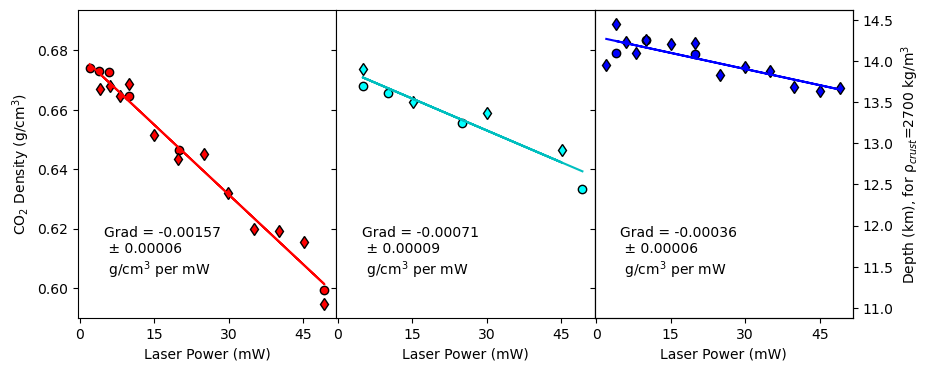

In [ ]:




# Create the plot
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (10,4), sharey=True, sharex=True,gridspec_kw={'wspace': 0})


## B22_1_FIA ##########################3
mask = df['filename'].str.contains('B22_1_FIA')
df_inclusion = df[mask]

# Plot points with and without 'down' separately
down_mask = df_inclusion['filename'].str.contains('down')
not_down_mask = ~down_mask

ax1.plot(df_inclusion[down_mask]['power (mW)'], df_inclusion[down_mask]['Density g/cm3'],
        'ok',  mfc='red', label='down')  # black circles

ax1.plot(df_inclusion[not_down_mask]['power (mW)'], df_inclusion[not_down_mask]['Density g/cm3'],
        'dk', mfc='red', label='not down')  # red circles

stats_a1=pt.calculate_R2(df_inclusion['power (mW)'], df_inclusion['Density g/cm3'])
ax1.plot(stats_a1['x_pred'], stats_a1['y_pred'], '-r')
print(np.max(stats_a1['y_pred']))
print(np.min(stats_a1['y_pred']))
ax1.annotate(
    f"Grad = {stats_a1['Grad'].item():.5f} \n ± {stats_a1['Grad_err'].item():.5f} \n g/cm$^{3}$ per mW",
    xy=(0.1, 0.3), xycoords="axes fraction",
    ha='left', va='top', fontsize=10
)



#### SEcond one
mask = df['filename'].str.contains('B26_c11_FIX')
df_inclusion = df[mask]

# Plot points with and without 'down' separately
down_mask = df_inclusion['filename'].str.contains('down')
not_down_mask = ~down_mask

ax2.plot(df_inclusion[down_mask]['power (mW)'], df_inclusion[down_mask]['Density g/cm3'],
        'ok',  mfc='cyan', label='down')  # black circles

ax2.plot(df_inclusion[not_down_mask]['power (mW)'], df_inclusion[not_down_mask]['Density g/cm3'],
        'dk', mfc='cyan', label='not down')  # red circles

stats_a1=pt.calculate_R2(df_inclusion['power (mW)'], df_inclusion['Density g/cm3'])
ax2.plot(stats_a1['x_pred'], stats_a1['y_pred'], '-c')
ax2.annotate(
    f"Grad = {stats_a1['Grad'].item():.5f} \n ± {stats_a1['Grad_err'].item():.5f} \n g/cm$^{3}$ per mW",
    xy=(0.1, 0.3), xycoords="axes fraction",
    ha='left', va='top', fontsize=10
)

## Final one

mask = df['filename'].str.contains('B31_c8')
df_inclusion = df[mask]

# Plot points with and without 'down' separately
down_mask = df_inclusion['filename'].str.contains('down')
not_down_mask = ~down_mask

ax3.plot(df_inclusion[down_mask]['power (mW)'], df_inclusion[down_mask]['Density g/cm3'],
        'ok',  mfc='blue', label='down')  # black circles

ax3.plot(df_inclusion[not_down_mask]['power (mW)'], df_inclusion[not_down_mask]['Density g/cm3'],
        'dk', mfc='blue', label='not down')  # red circles

stats_a1=pt.calculate_R2(df_inclusion['power (mW)'], df_inclusion['Density g/cm3'])
ax3.plot(stats_a1['x_pred'], stats_a1['y_pred'], '-b')
ax3.annotate(
    f"Grad = {stats_a1['Grad'].item():.5f} \n ± {stats_a1['Grad_err'].item():.5f} \n g/cm$^{3}$ per mW",
    xy=(0.1, 0.3), xycoords="axes fraction",
    ha='left', va='top', fontsize=10
)


####### Axis labels
ax1.set_xticks([0, 15, 30, 45])

ax1.set_xlabel('Laser Power (mW)')
ax1.set_ylabel('CO$_2$ Density (g/cm$^{3}$)')
ax2.set_xlabel('Laser Power (mW)')
ax3.set_xlabel('Laser Power (mW)')



import DiadFit as pf

def get_depth_for_rho(rho, T_K=1200+273.15):
    P_kbar = pf.calculate_P_for_rho_T(CO2_dens_gcm3=rho, T_K=T_K)['P_kbar']
    return (1e5 * P_kbar / (9.8 * 2700)).item()

# === For ax1 ===
ax1b = ax3.twinx()
ymax1 = ax1.get_ylim()[1]
ymin1=ax1.get_ylim()[0]
depth1 = get_depth_for_rho(ymax1)
depth2 = get_depth_for_rho(ymin1)
ax1b.set_ylim(depth2, depth1)
ax1b.set_ylabel('Depth (km), for ρ$_{crust}$=2700 kg/m$^3$')

fig.savefig('PowerSeries_Iceland.png', dpi=300, transparent=True)

In [ ]:
import DiadFit as pf
P_067=pf.calculate_P_for_rho_T(CO2_dens_gcm3=0.92, T_K=1200+273.15)
D=10**5*P_067['P_kbar']/(9.8*2700)
D

0    26.320642
Name: P_kbar, dtype: float64

In [ ]:
import DiadFit as pf
P_067=pf.calculate_P_for_rho_T(CO2_dens_gcm3=0.775, T_K=1200+273.15)
D=10**5*P_067['P_kbar']/(9.8*2700)
D

0    18.20109
Name: P_kbar, dtype: float64

## Charlottes Published data

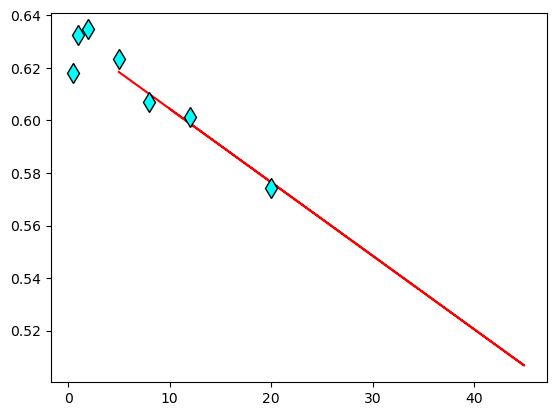

In [ ]:
df_Volc=pd.read_excel(r'C:\Users\penny\Box\Berkeley_new\Raman\Raman technical paper\Laser_power_Series\DeVitre_Volcanica_Series.xlsx')
df_Volc_63=df_Volc.loc[df_Volc['VAPOR_BUBBLE_NAME'].str.contains('63')]
df_Volc_28=df_Volc.loc[df_Volc['VAPOR_BUBBLE_NAME'].str.contains('28')]
df_Volc_51=df_Volc.loc[df_Volc['VAPOR_BUBBLE_NAME'].str.contains('51')]


df=df_Volc_63
plt.errorbar(df['power (mW)'], df['Density using Eq(2) (g/mL)'], xerr=0, yerr=0, fmt='d', ecolor='k', elinewidth=0.8, mfc='cyan', ms=10, mec='k', capsize=3 )
stats=pt.calculate_R2(df['power (mW)'], df['Density using Eq(2) (g/mL)'], df=True)
stats.to_clipboard(excel=True, header=False)
plt.plot(x, stats['Grad'].iloc[0]*x+stats['Int'].iloc[0], '-r')


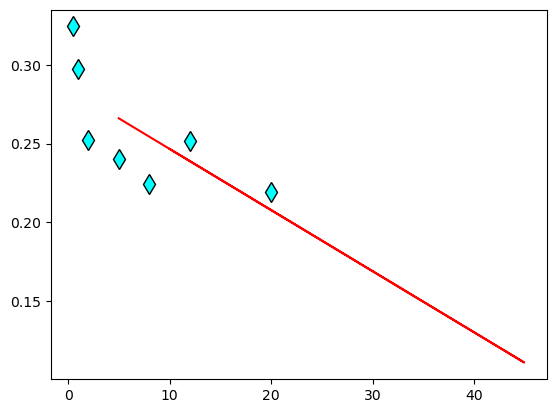

In [ ]:
df=df_Volc_28
plt.errorbar(df['power (mW)'], df['Density using Eq(2) (g/mL)'], xerr=0, yerr=0, fmt='d', ecolor='k', elinewidth=0.8, mfc='cyan', ms=10, mec='k', capsize=3 )
stats=pt.calculate_R2(df['power (mW)'], df['Density using Eq(2) (g/mL)'], df=True)
stats.to_clipboard(excel=True, header=False)
plt.plot(x, stats['Grad'].iloc[0]*x+stats['Int'].iloc[0], '-r')

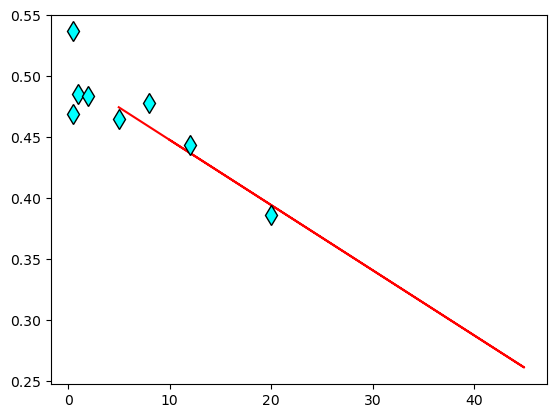

In [ ]:
df=df_Volc_51
plt.errorbar(df['power (mW)'], df['Density using Eq(2) (g/mL)'], xerr=0, yerr=0, fmt='d', ecolor='k', elinewidth=0.8, mfc='cyan', ms=10, mec='k', capsize=3 )
stats=pt.calculate_R2(df['power (mW)'], df['Density using Eq(2) (g/mL)'], df=True)
stats.to_clipboard(excel=True, header=False)
plt.plot(x, stats['Grad'].iloc[0]*x+stats['Int'].iloc[0], '-r')

## Lets grab them together

In [ ]:

df_Volc

,Analyist,Type,df_name,Sample Name,Unnamed: 4,R2,RMSE,RMSE_num,P_val,Median,Mean,Int,Grad,Grad_err,x_pred,y_pred
22,Charlotte,MI,df_Volc_63,bubble63,0,0.89325,9.12694,9.12694,0.00132,-4.37666,-6.31552,0.632432,-0.002797,0.00043,0.5\n 1. \n 2. \n 5. \n 8. \n 12. \n 20.,0.63103335\n 0.62963494\n 0.62683812\n 0.61844...
23,Charlotte,MI,df_Volc_28,Bubble28,0,0.50815,9.38078,9.38078,0.07219,-4.75996,-6.67003,0.285435,-0.003881,0.00171,0.5\n 1. \n 2. \n 5. \n 8. \n 12. \n 20.,0.2834947 \n 0.28155425\n 0.27767336\n 0.26603...
24,Charlotte,MI,df_Volc_51,Bubble51,0,0.75865,8.64574,8.64574,0.00486,-3.02571,-5.65672,0.500993,-0.005341,0.00123,0.5\n 1. \n 2. \n 5. \n 8. \n 12. \n 20. ...,0.49832209\n 0.49565136\n 0.4903099 \n 0.47428...


In [ ]:
df_all_excel

,Analyist,Type,df_name,Sample Name,Unnamed: 4,R2,RMSE,RMSE_num,P_val,Median,Mean,Int,Grad,Grad_err,x_pred,y_pred
0,Alex,MI,df_March21,ML22_77_4_MIA,0,0.79873,20.06479,20.06479,0.00667,-12.03080,-17.01277,0.020274,-0.000481,0.00011,4.98 \n 12.001\n 24.986\n 35.028\n 25.095\n 1...,0.0178786 \n 0.01450214\n 0.00825753\n 0.00342...
1,Alex,MI,df_March21_2,MP2_204_MIA_5mW,0,0.70220,21.16696,21.16696,0.00247,-15.01822,-18.38773,0.021015,-0.000437,0.00010,5.03 \n 11.955\n 14.982\n 24.988\n 34.977\n 3...,0.01881474\n 0.01578552\n 0.01446141\n 0.01008...
2,Alex,MI,df_March27,ML22_77_4,0,0.32265,21.14135,21.14135,0.08671,-14.97799,-18.37130,0.015594,-0.000440,0.00023,5.027\n 11.974\n 14.946\n 24.924\n 34.945\n 3...,0.01338041\n 0.01032125\n 0.00901251\n 0.00461...
3,Charlotte,FI,df_CF_9,FG04-A11-9,0,0.56341,22.35310,22.35310,0.00021,-15.84953,-17.90256,0.115568,-0.000416,0.00009,4.023\n 4.023\n 4.014\n 7.919\n 11.925\n 1...,0.11389441\n 0.11389441\n 0.11389815\n 0.11227...
4,Charlotte,FI,df_CF_16,FG04-A11-16,0,0.70132,23.48823,23.48823,0.00003,-15.84360,-19.43506,0.217504,-0.000298,0.00005,4.04 \n 7.992\n 11.98 \n 15.968\n 19.962\n 2...,0.21629979\n 0.21512196\n 0.21393341\n 0.21274...
5,Charlotte,FI,df_CF_4,FG04-A11-4,0,0.87028,23.68791,23.68791,0.00000,-17.47548,-19.38328,0.539576,-0.002695,0.00028,4.008\n 8.006\n 11.938\n 15.951\n 19.943\n 2...,0.52877633\n 0.51800339\n 0.50740829\n 0.49659...
6,Penny,FI,df_MP,p3_FI4_50x,0,0.42845,19.08660,19.08660,0.00810,-14.00592,-16.53699,1.000605,-0.000243,0.00008,4\n 8\n 12\n 15\n 20\n 25\n 30\n 35\n 30\n 2...,0.9996335 \n 0.99866242\n 0.99769134\n 0.99696...
7,P/C?,FI,df_101_Nov6,FG19_101_FIB,0,0.07148,24.80910,24.80910,0.12051,-18.96421,-20.67402,0.902449,-0.000072,0.00005,3.991\n 3.962\n 3.947\n 8.002\n 8.038\n ...,0.9021606 \n 0.90216269\n 0.90216378\n 0.90187...
8,P/C?,FI,df_A13,FG04_A13_12,0,0.59524,18.86995,18.86995,0.00000,-14.22622,-15.49079,0.716462,-0.000440,0.00005,4.021\n 3.988\n 3.956\n 6.018\n 6.097\n ...,0.71469144\n 0.71470597\n 0.71472006\n 0.71381...
9,P/C?,MI,df_Fo1,FO1,0,0.78386,21.79125,21.79125,0.00000,-15.90395,-17.96248,0.091632,-0.000687,0.00007,4.017\n 4.015\n 4.012\n 7.964\n 7.972\n ...,0.08887239\n 0.08887377\n 0.08887583\n 0.08616...


Text(0, 0.5, 'Gradient (g/cm3 per mW)')

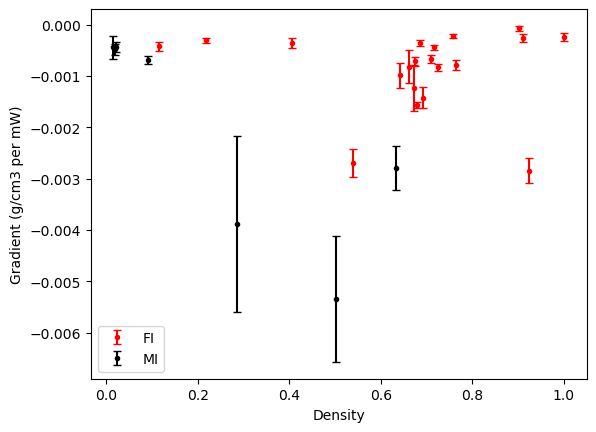

In [ ]:
# FI
plt.errorbar(df_all_excel['Int'].loc[df_all_excel['Type']=='FI'], 
             df_all_excel['Grad'].loc[df_all_excel['Type']=='FI'], 
             yerr=df_all_excel['Grad_err'].loc[df_all_excel['Type']=='FI'], 
             fmt='.r', capsize=3, label='FI')
plt.plot()
# MI
plt.errorbar(df_all_excel['Int'].loc[df_all_excel['Type']=='MI'], 
             df_all_excel['Grad'].loc[df_all_excel['Type']=='MI'], 
             yerr=df_all_excel['Grad_err'].loc[df_all_excel['Type']=='MI'], 
             fmt='.k', capsize=3, label='MI')
plt.legend()
plt.xlabel('Density')
plt.ylabel('Gradient (g/cm3 per mW)')

## Ones I have both heating and power series for